This notebook is used to make plots. The notebook is converted to a plain python text file using [jupytext](https://jupytext.readthedocs.io/en/latest/)

In [111]:
import os
import numpy as np
import pandas as pd

In [2]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
# print(os.getcwd())
# !module load python-data/3.7.6-1
# !python -m pip install jupytext
!python -m jupytext --sync MakePlots.ipynb

[jupytext] Reading MakePlots.ipynb in format ipynb
[jupytext] Updating MakePlots.py


# Energy (x) vs Uncertainty (y) plot
In this plot we load the python model for each batch in run 1 of a given Dataset/Strategy/Batches combo (e.g. AA_D_EXP ) and make a plot which shows where was the uncertainty reduced the most. The data for this plot is present in `Puhti` under `/scratch/project_2000382/ghoshkun/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs`

In [112]:
import os
os.getcwd()

'/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs'

Set the current working directory to where the data exists

In [113]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
assert os.getcwd() == "/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs"

# Plot A vs D

In [226]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib as mpl
%matplotlib inline

def set_mpl_params(matplotlib):
    plt.figure(figsize=(6,4), dpi=200)
    # formatting plots
    font = {'family' : 'monospace', 'size'   : 15, 'sans-serif':'Nimbus'}
    lines = {"linewidth": 4}

    matplotlib.rc('font', **font)
    matplotlib.rc('lines', **lines)
    
def get_labels():
    labels = "A B C D E F G".split(" ")
    labs = [[_] for _ in labels]
    return labs, labels

def set_mpl_params_meeting(matplotlib):
    plt.figure(figsize=(6,4), dpi=100)
    # formatting plots
    font = {'family' : 'monospace', 'size'   : 10, 'sans-serif':'Nimbus'}
    lines = {"linewidth": 2}

    matplotlib.rc('font', **font)
    matplotlib.rc('lines', **lines)

In [213]:
def get_msb(aa_a):
    batch_sizes = np.cumsum(aa_a.batch_size.to_numpy()) // 1000
    means = aa_a.mean_vals.to_numpy()
    stds = aa_a.std_vals.to_numpy()
    return means, stds, batch_sizes

def get_means_stds_batchsize(aa_a, aa_d):
    assert (aa_a.batch_size == aa_d.batch_size).all(), "batch_size column must be the same, in the two files passed in the argument."

    # batch_sizes = np.arange(0,17,batch_size) + 1
    batch_sizes = np.cumsum(aa_a.batch_size.to_numpy()) // 1000

    aa_a_means = aa_a.mean_vals.to_numpy()
    aa_d_means = aa_d.mean_vals.to_numpy()

    aa_a_stds = aa_a.std_vals.to_numpy()
    aa_d_stds = aa_d.std_vals.to_numpy()

    stds = [aa_a_stds,
         [],
         [],
         aa_d_stds,
         [],
         [],
         []]

    means = [aa_a_means,
         [],
         [],
         aa_d_means,
         [],
         [],
         []]
    return means, stds, batch_sizes

In [116]:
def plot_strategy_a_vs_d(dataset_name, means, stds, labels):
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            _ = plt.errorbar(batch_sizes, mean, std) #, capsize=lines['linewidth'])
            _ = plt.scatter(batch_sizes, mean, label=labels[idx])
    plt.grid()
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("MAE (eV)")
    plt.gca().tick_params(axis='x', which='minor', bottom=True)
    plt.xscale("linear")
    #plt.xlim((0, 33))
    plt.ylim((0,0.6))
    # plt.xscale("log", basex=2)
    #     sformatter = mpl.ticker.ScalarFormatter()
    #     sformatter.set_scientific(False)
    formatter = mpl.ticker.FuncFormatter(lambda y, _: '{:0.0f}'.format(y))
    # use plt.gca() whenever there is a need for axis.<something>
    plt.gca().xaxis.set_major_formatter(formatter)
    
    #plt.xticks(range(0, 33))
    if dataset_name:
        plt.title(f"{dataset_name} - Strategy A vs D")

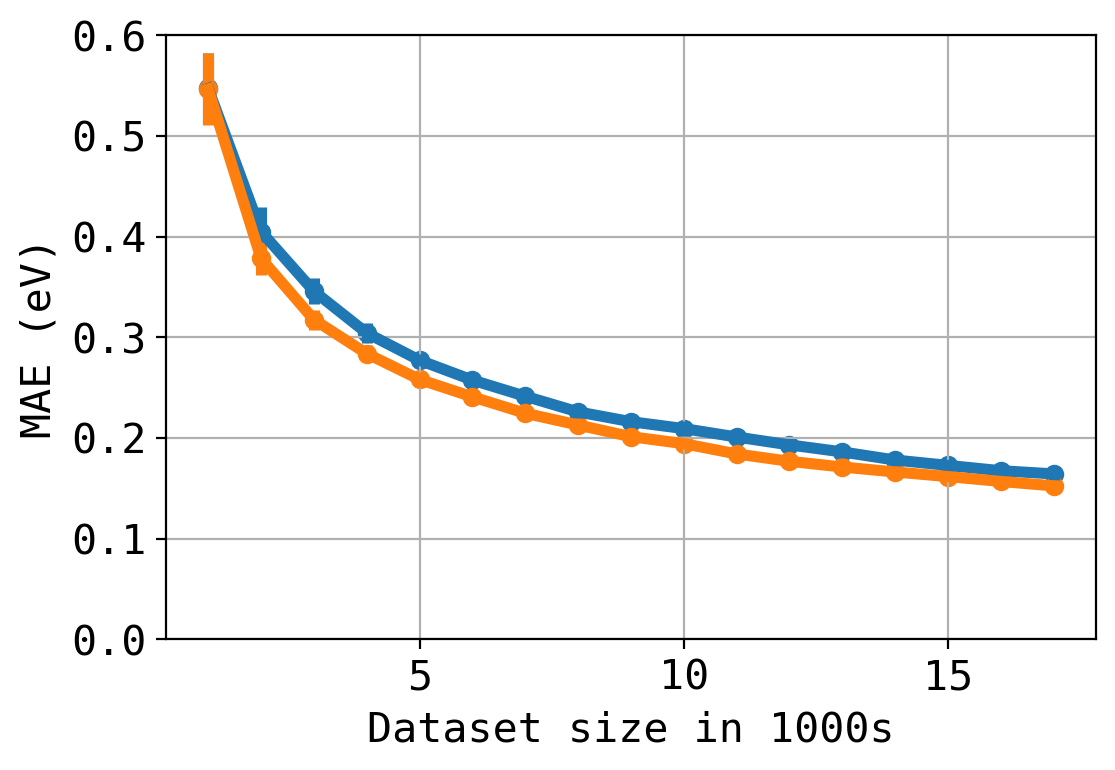

In [117]:
aa_a = pd.read_csv("csv_files/Active_learning_results - AA_A_1k.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - AA_D_1k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

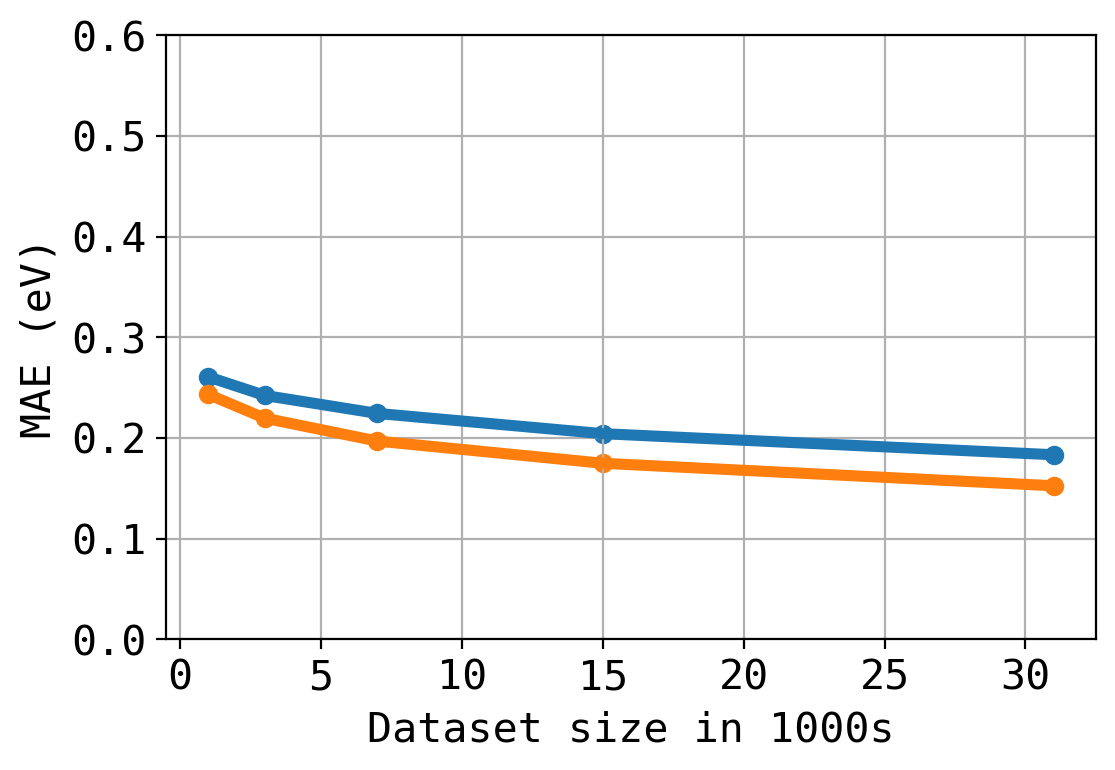

In [118]:
aa_a = pd.read_csv("csv_files/Active_learning_results - QM9_A_EXP_physdays.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - QM9_D_EXP_physdays.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

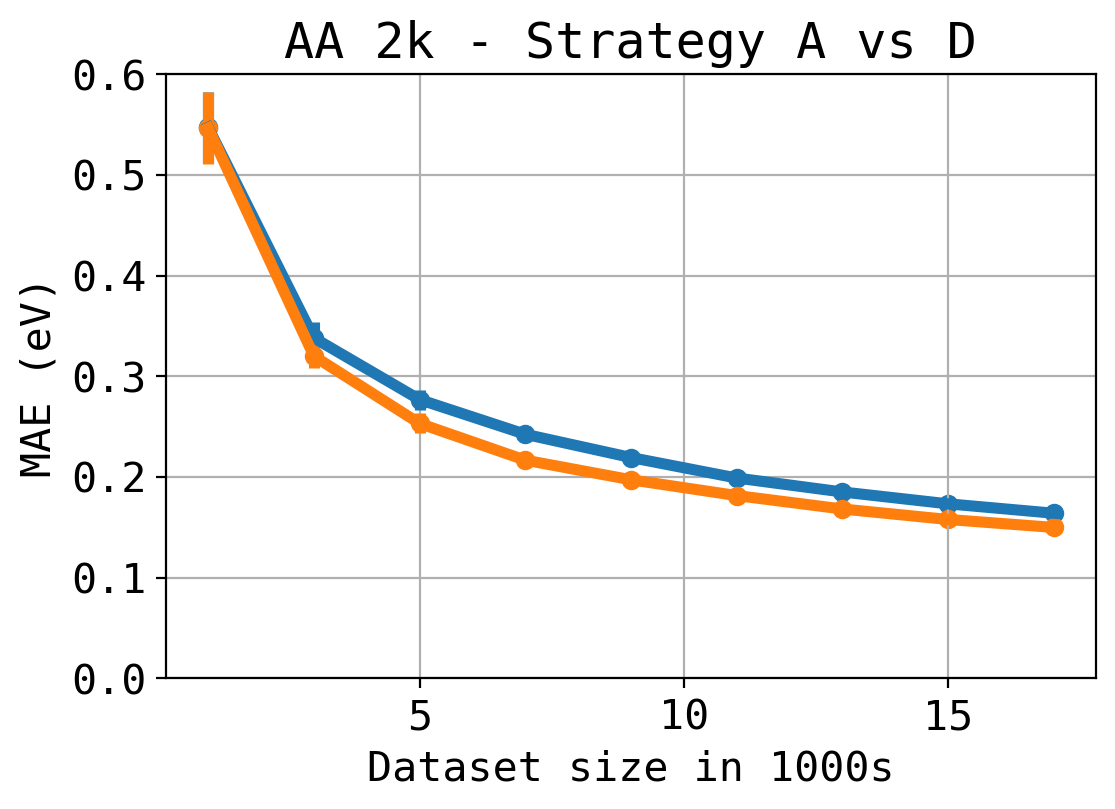

In [119]:
aa_a = pd.read_csv("csv_files/Active_learning_results - AA_A_2k.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - AA_D_2k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "AA 2k", means=means, stds=stds, labels=labels)    

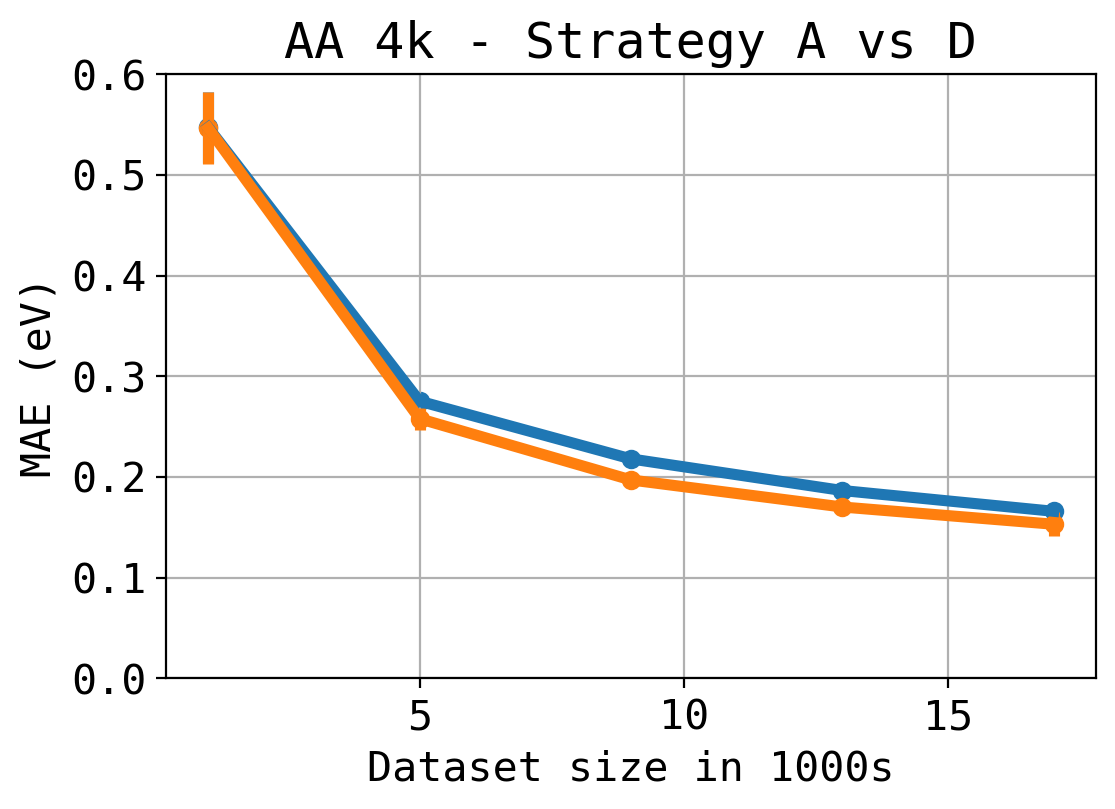

In [120]:
aa_a = pd.read_csv("csv_files/Active_learning_results - AA_A_4k.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - AA_D_4k.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "AA 4k", means=means, stds=stds, labels=labels) 

[ 1  3  7 15 31]


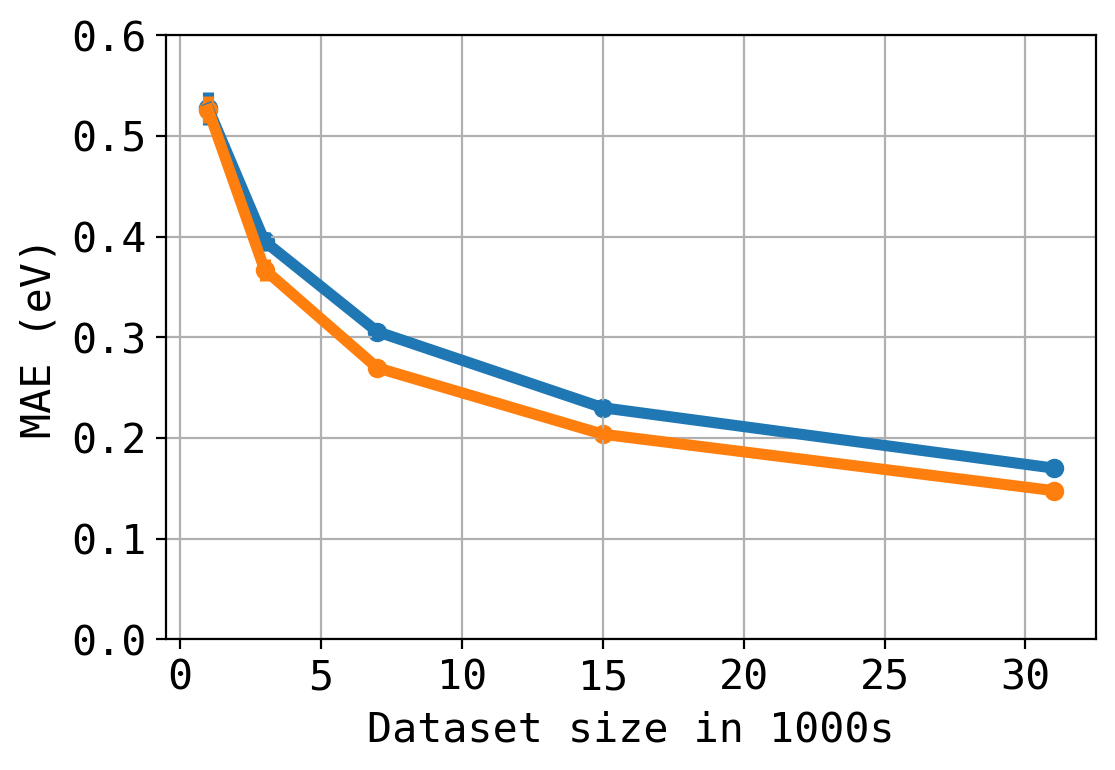

In [121]:
aa_a = pd.read_csv("csv_files/Active_learning_results - AA_A_EXP_old.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - AA_D_EXP_old.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    

[ 1  3  7 15 31]


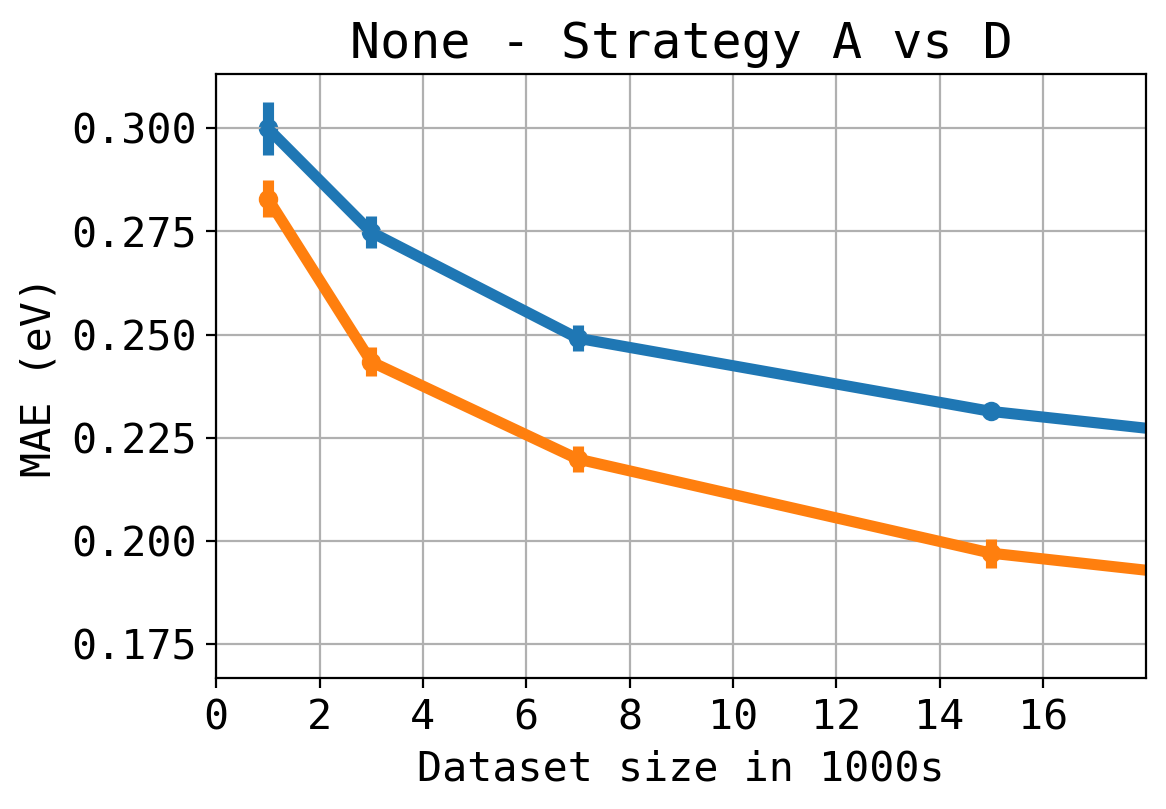

In [52]:
aa_a = pd.read_csv("csv_files/Active_learning_results - QM9_A_EXP_old.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - QM9_D_EXP_old.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    


[ 1  2  4  8 16 32]


(0.1, 0.3)

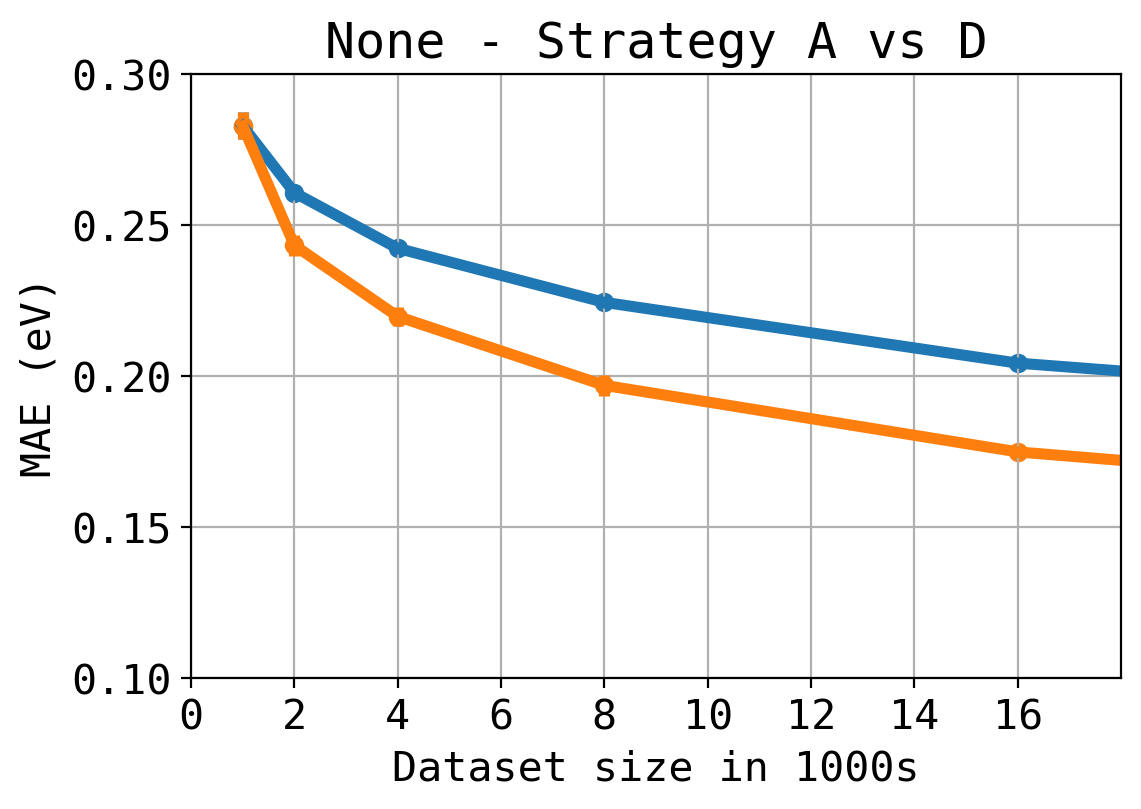

In [53]:
aa_a = pd.read_csv("csv_files/Active_learning_results - QM9_A_EXP.csv")
aa_d = pd.read_csv("csv_files/Active_learning_results - QM9_D_EXP.csv")

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = None, means=means, stds=stds, labels=labels)    
plt.ylim(0.1, 0.3)

[1 2 4 8]


(0.23684202173779997, 0.3116408430262)

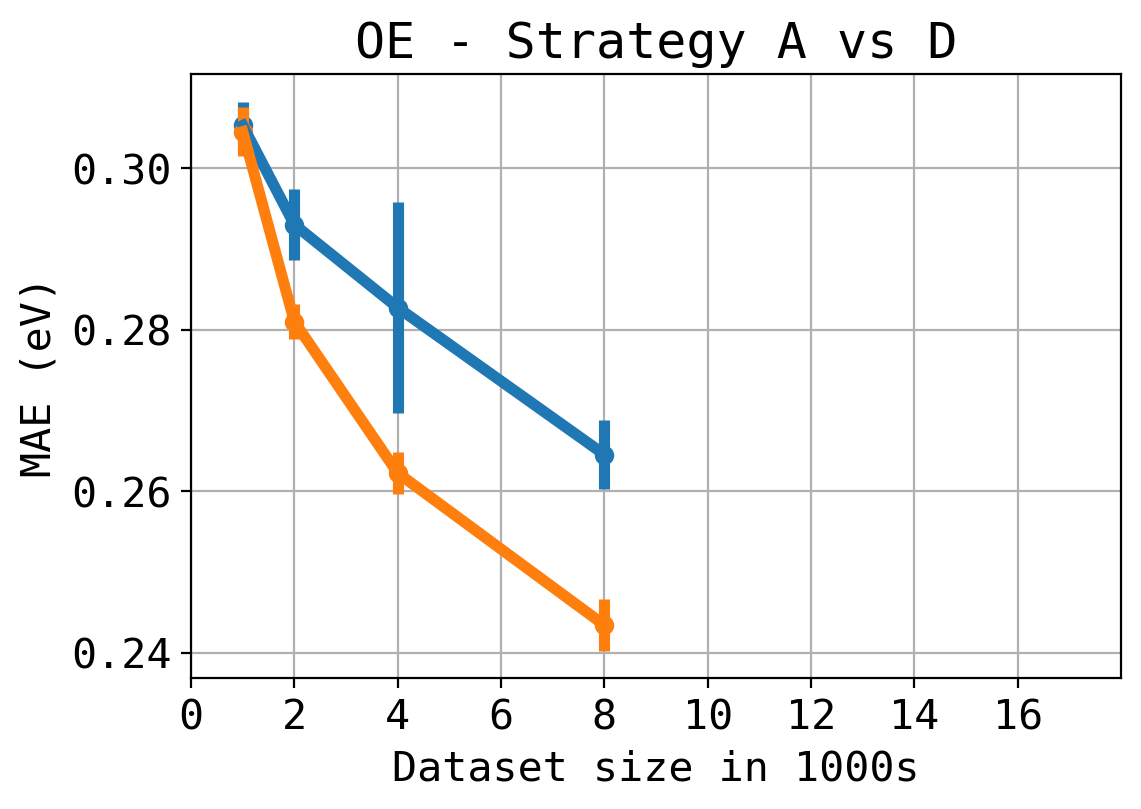

In [54]:
aa_a = pd.read_csv("csv_files/Active_learning_results - OE_A_EXP.csv")[:-1]
aa_d = pd.read_csv("csv_files/Active_learning_results - OE_D_EXP.csv")[:-1]

means, stds, batch_sizes = get_means_stds_batchsize(aa_a,aa_d)
print(batch_sizes)
set_mpl_params(matplotlib)
labs, labels = get_labels()
plot_strategy_a_vs_d(dataset_name = "OE", means=means, stds=stds, labels=labels)  
plt.ylim()

TODO : For the plot with the new data, save the means and standard deviation.

# Data savings plot

The code is based on the original implementation in 

In [124]:
from scipy.optimize import curve_fit
import numpy as np

def fit_curve_to_data(means, stds, labels, batch_sizes):
     # np.random.seed(0)
    coeffs = { 'A' : None, 'D' : None }
    mean_dict = {'A' : None, 'D' : None}
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
#             results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [3., 1., 2, 2]), maxfev=10000)
            results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [1., 1., 2, 2]), maxfev=10000)
            a, b, c, d= results[0]
            coeffs[labels[idx]] = results[0]
            mean_dict[labels[idx]] = mean

            x = batch_sizes # np.arange(0, 17, batch_size)
            y = d + (a-d)/(1 + (x/c)**b)

    return coeffs, mean_dict


# fit_curve_to_data(means, stds, labels, batch_sizes)

In [125]:
def plot_strategy_a_vs_d(dataset_name, means, stds, labels):
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            _ = plt.errorbar(batch_sizes, mean, std)#, capsize=lines['linewidth'])
            _ = plt.scatter(batch_sizes, mean, label=labels[idx])
    plt.grid()
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("MAE (eV)")
    plt.xlim((0, 18))
    plt.xticks(range(0, 17, 2))
    plt.title(f"{dataset_name} - Strategy A vs D")
    
# plot_strategy_a_vs_d(dataset_name = "AA", means=means, stds=stds)    

In [126]:
def get_data_savings(mean_dict, coeffs, batch_size, batch_sizes):
    # xticks = [_ for _ in range(0,17,batch_size)]
    data_saving = []
    a,b,c,d = coeffs['D']
    for y, batch_size in zip(mean_dict['A'], batch_sizes):
        x = c * (-1 + (a-d)/(y-d))**(1./b)
        # xticks.append(x)
        data_saving.append(batch_size - x)

#     xticks.sort()
#     xticks_str = []
#     for idx, x in enumerate(xticks):
#         if x in batch_sizes:
#             xticks_str.append(" ")
#         else:
#             xticks_str.append("%.2f" % x)
    return data_saving

# get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)

[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]


(array([ 0.28536705, 12.23964187, 20.53751735, 21.53121709, 19.19103616]),
 array([ 1,  5,  9, 13, 17]))

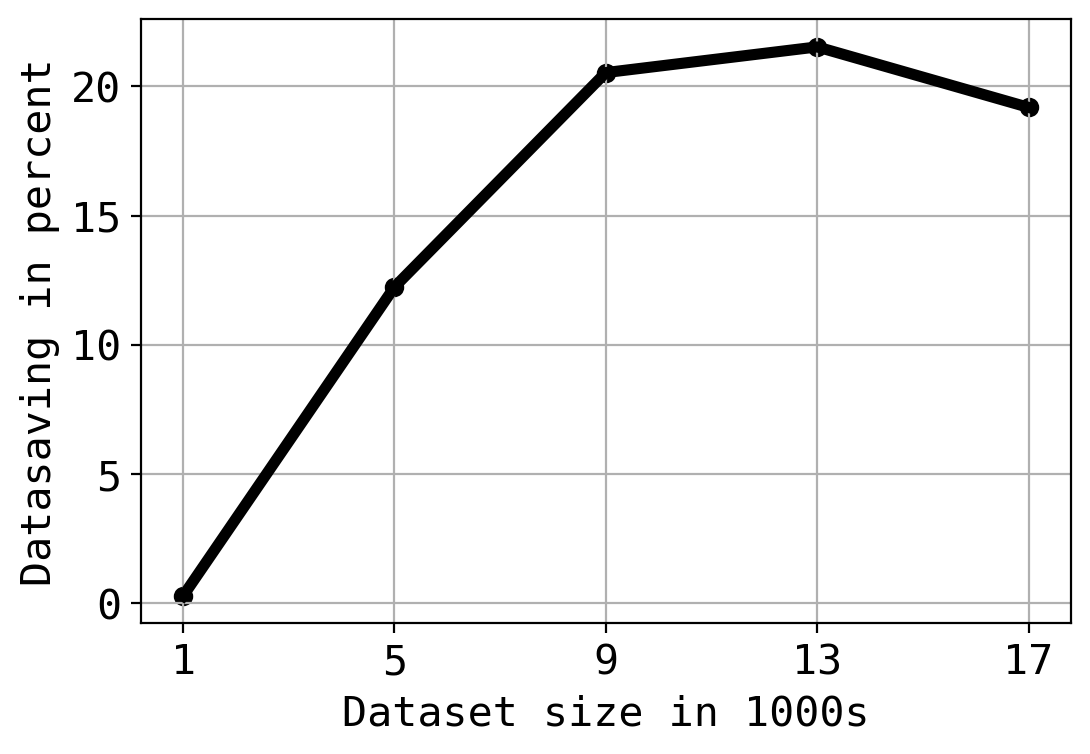

In [127]:
import os
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def plot_data_savings(strategy_a_file, strategy_d_file, batch_size, percentage=False):
    aa_a = pd.read_csv(strategy_a_file)
    aa_d = pd.read_csv(strategy_d_file)

    set_mpl_params(matplotlib)
    
    labs, labels = get_labels()
    
    means, stds, batch_sizes = get_means_stds_batchsize(aa_a, aa_d)
    # print(means[0], means[3], batch_sizes)
    
    coeffs, mean_dict = fit_curve_to_data(means, stds, labels, batch_sizes)
    # print(coeffs)
    data_saving = get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)
    
    data_saving = np.array(data_saving)
    batch_sizes = np.array(batch_sizes)

    print(data_saving)
    if percentage:
        data_saving = 100 * data_saving / (batch_sizes)
        
    plt.plot(batch_sizes, data_saving, color="k")
    plt.scatter(batch_sizes, data_saving, color="k")#, label="Datasaving (D vs A) in percent")
    plt.xscale("linear")
    # plt.legend()
    plt.xticks(batch_sizes)
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    return data_saving, batch_sizes
    
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")    
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_4k.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_4k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.42048204  1.84002063  4.72486557 10.14536478 20.31025282]


(array([42.04820375, 61.33402094, 67.49807961, 67.63576523, 65.51694459]),
 array([ 1,  3,  7, 15, 31]))

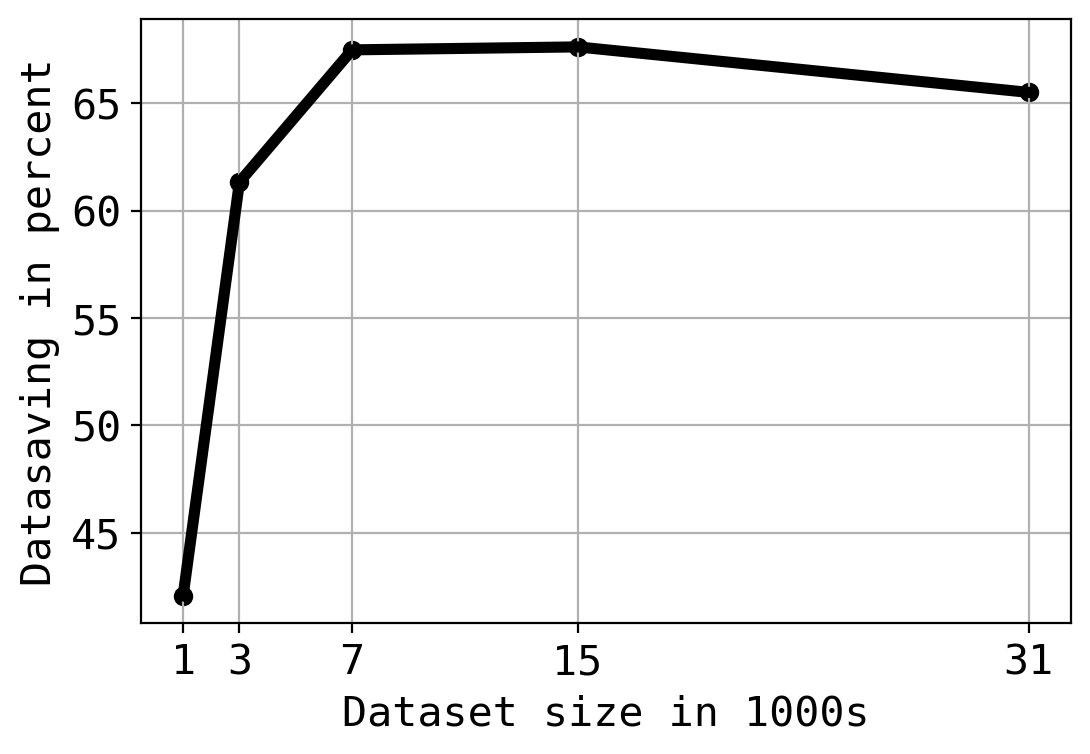

In [128]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - QM9_A_EXP_physdays.csv",
                  strategy_d_file = "csv_files/Active_learning_results - QM9_D_EXP_physdays.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[0.01652902 0.51814443 1.94976298 4.52693594 8.4964847 ]


array([ 1,  3,  7, 15, 31])

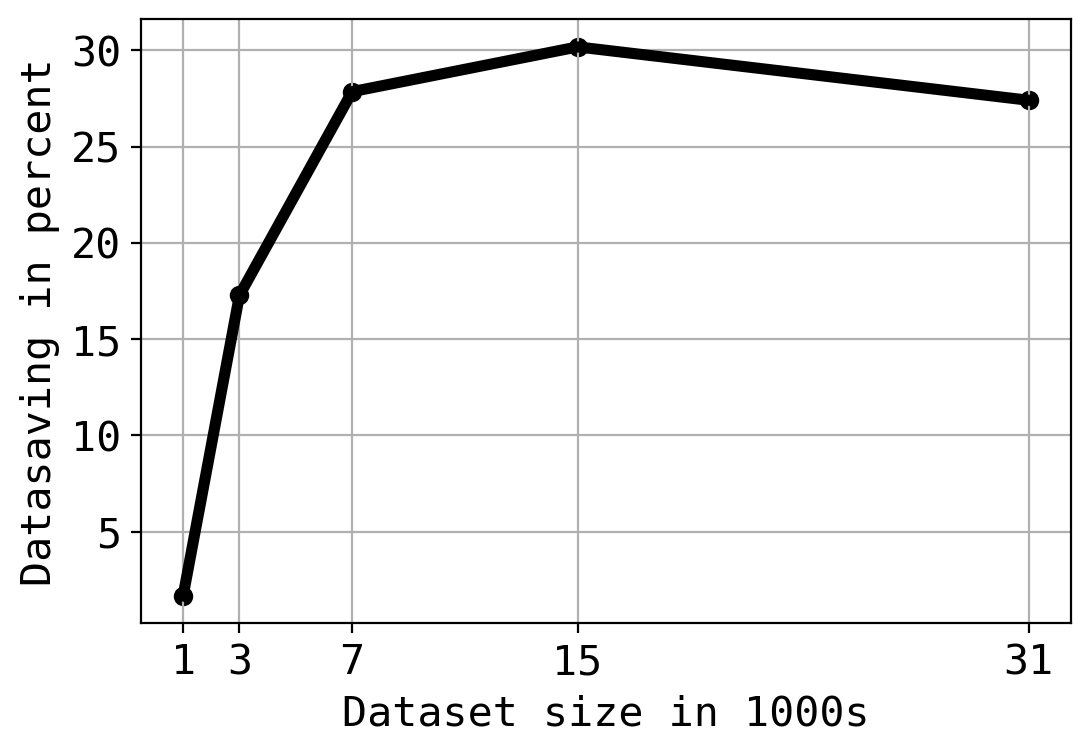

In [129]:
# compute data savings plot for QM9
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")    
savings_aa, batch_size_aa = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP_old.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP_old.csv",
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc
# [ 0.04438062 -0.2239867   0.03023715  0.52630918  0.93471799 -2.68499825]
batch_size_aa

[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]


(array([ 0.85901476,  7.46445789, 17.46969645, 22.63673399, 25.38857858,
        23.74930569, 22.99961434, 20.65631587, 18.03414687]),
 array([ 1,  3,  5,  7,  9, 11, 13, 15, 17]))

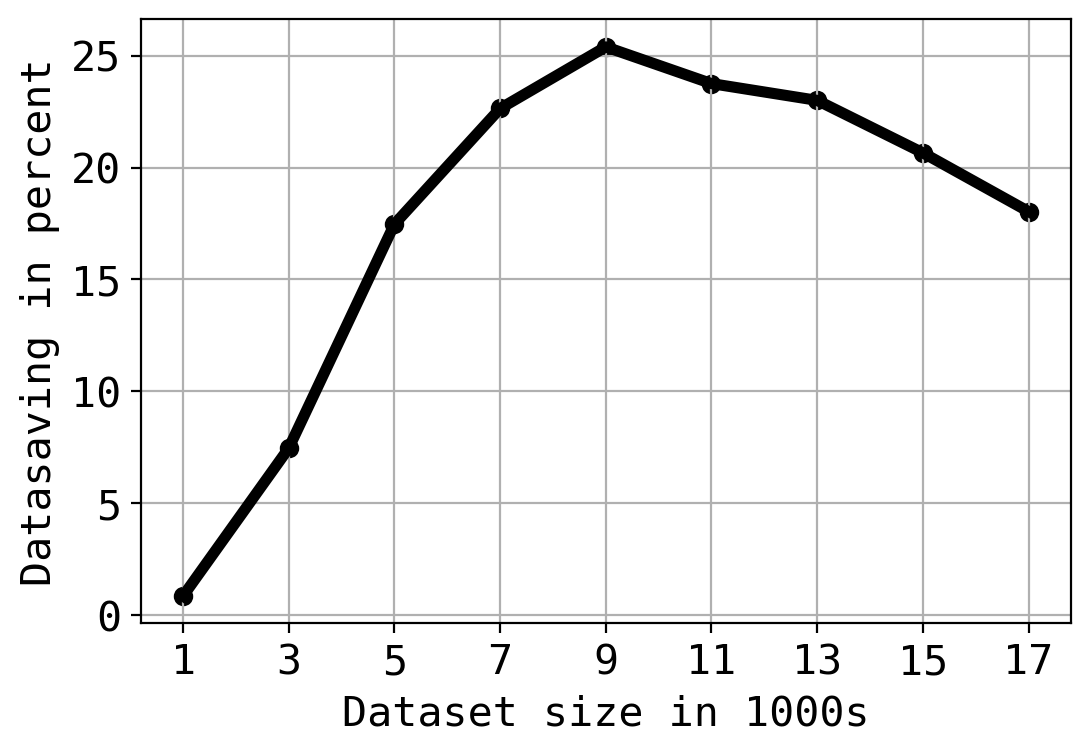

In [130]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_2k.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_2k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]


(array([ 4.6624874 ,  5.15470146, 12.1492982 , 14.28388769, 16.76875408,
        18.93279167, 20.06724117, 18.76164319, 20.00757328, 22.25913674,
        21.84892072, 20.69684661, 19.24923425, 15.14996977, 13.4389279 ,
        10.74036258, 10.6934899 ]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))

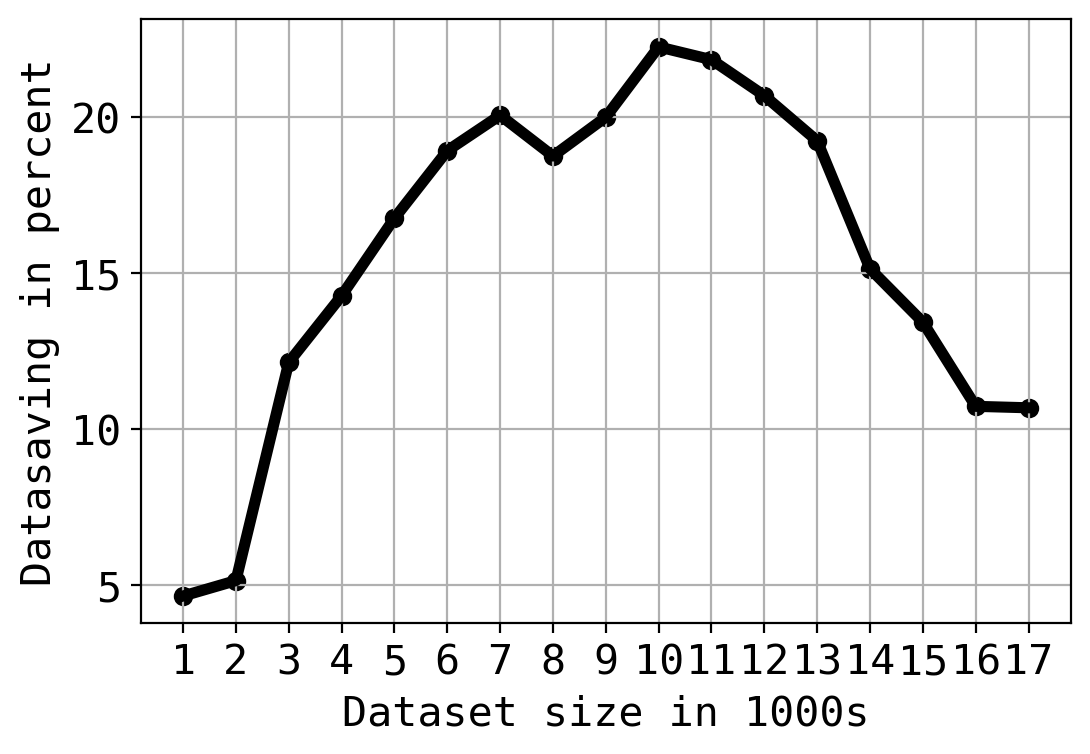

In [131]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.39477499  1.75762314  4.32339694 10.34945319 21.56542476]


(array([39.47749869, 58.58743787, 61.76281345, 68.99635463, 69.56588632]),
 array([ 1,  3,  7, 15, 31]))

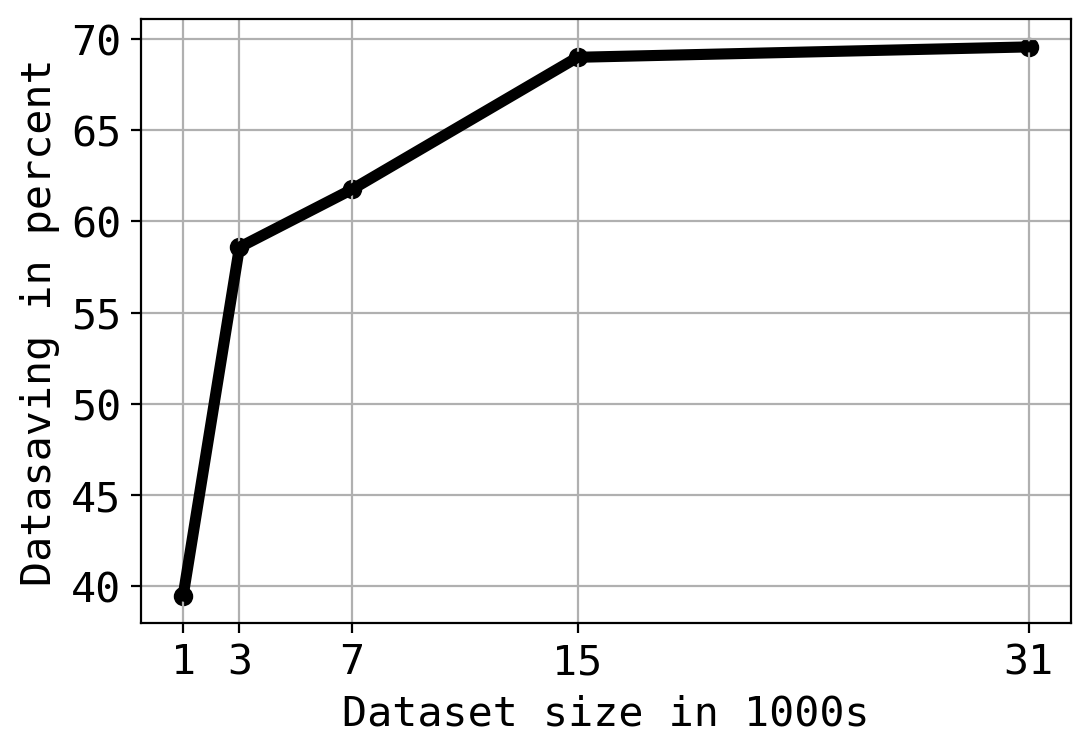

In [132]:
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - QM9_A_EXP_old.csv",
                  strategy_d_file = "csv_files/Active_learning_results - QM9_D_EXP_old.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

[ 0.04893794  0.48989654  1.71384548  4.4687283   9.95863202 20.66008899]


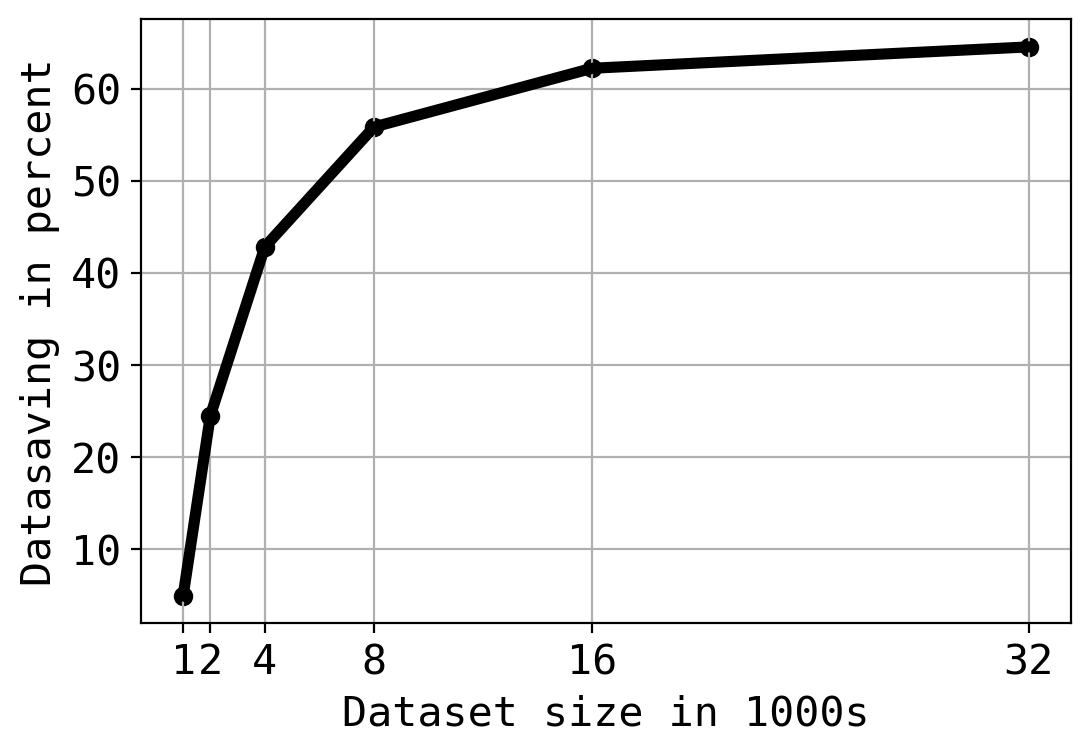

In [133]:
savings_qm9, batch_size_qm9 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - QM9_A_EXP.csv",
                  strategy_d_file = "csv_files/Active_learning_results - QM9_D_EXP.csv", 
                  batch_size=1,
                  percentage=True) # 1 for 1k, 2 for 2k etc

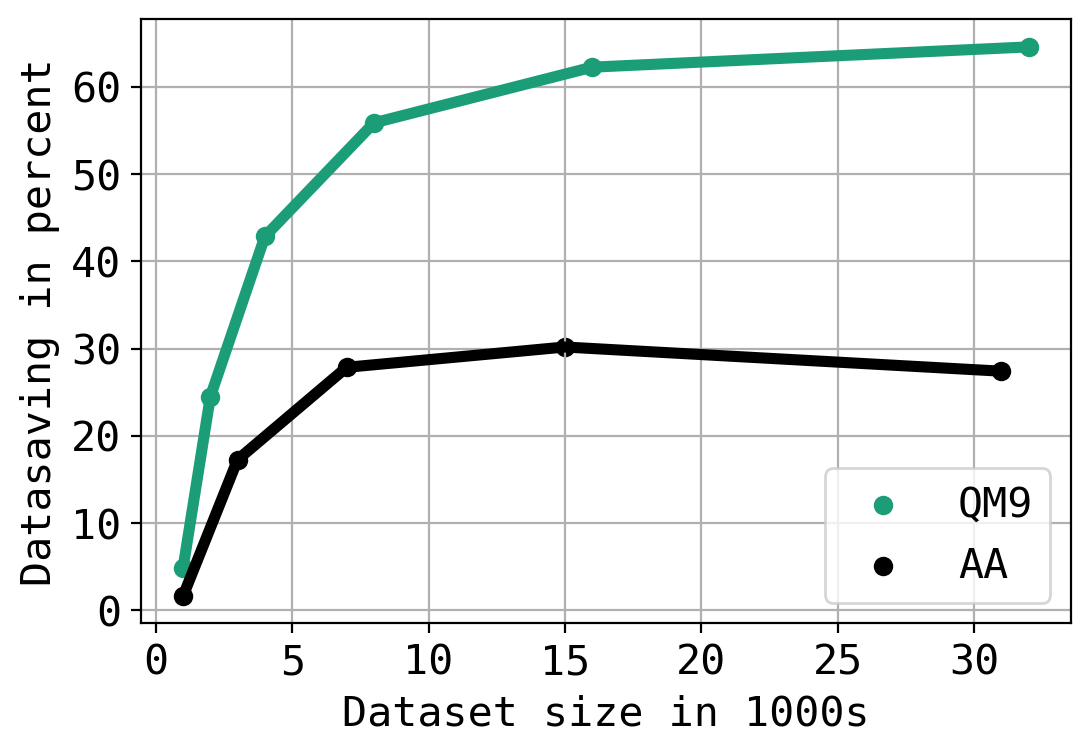

In [134]:
def plot_datasavings_qm9_aa():
    set_mpl_params(matplotlib)
    plt.plot(batch_size_qm9, savings_qm9, color="#1b9e77")
    plt.scatter(batch_size_qm9, savings_qm9, color="#1b9e77", label="QM9")

    plt.plot(batch_size_aa, savings_aa, color="k")
    plt.scatter(batch_size_aa, savings_aa, color="k", label="AA")

    # plt.xscale("linear")
    plt.legend()
    #plt.xticks(batch_sizes)
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    
plot_datasavings_qm9_aa()

<Figure size 1200x800 with 0 Axes>

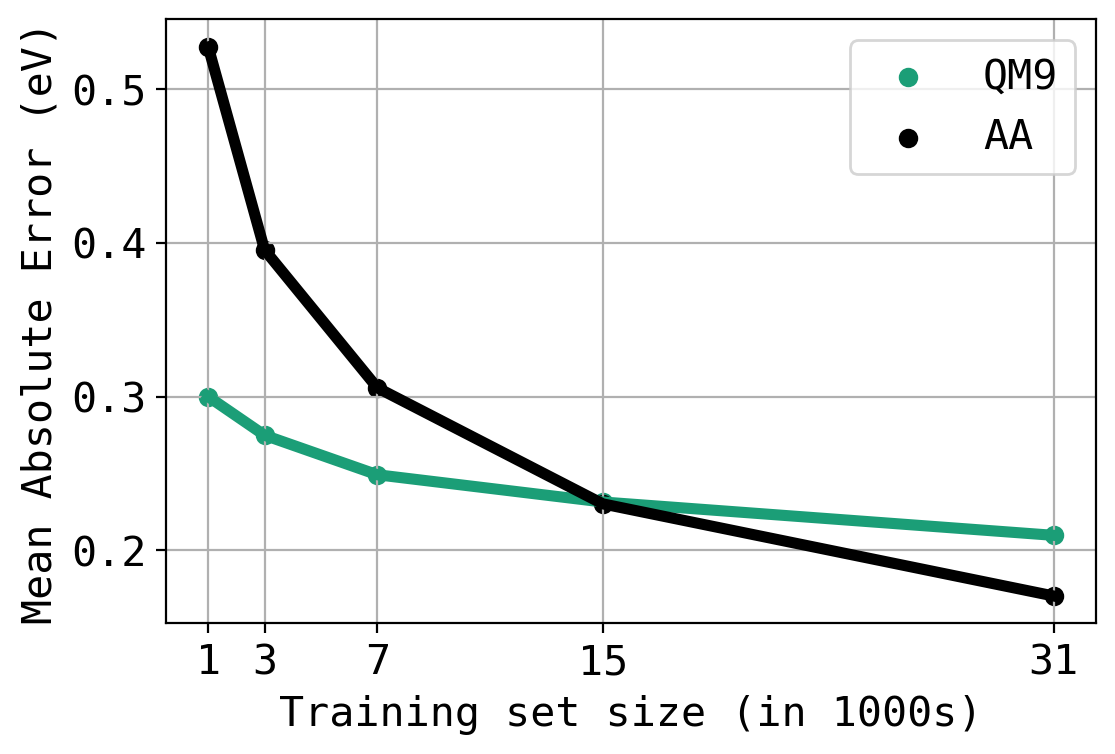

In [135]:
def plot_figure_1(aa, qm9):
    aa_a = pd.read_csv(aa)
    qm9_a = pd.read_csv(qm9)

    set_mpl_params(matplotlib)
    plt.figure(figsize=(6,4), dpi=200)
    labs, labels = get_labels()
    
    batch_size = np.cumsum(qm9_a.batch_size // 1000)
    
    plt.plot(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77")
    plt.scatter(batch_size, qm9_a.mean_vals.to_numpy(), color="#1b9e77", label="QM9")
    
    plt.plot(batch_size, aa_a.mean_vals.to_numpy(), color="k")
    plt.scatter(batch_size, aa_a.mean_vals.to_numpy(), color="k", label="AA")
    
    plt.xticks(batch_size)
    # plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

plot_figure_1("csv_files/Active_learning_results - AA_A_EXP_old.csv", 
              "csv_files/Active_learning_results - QM9_A_EXP_old.csv")

[ 1  2  4  8 16]


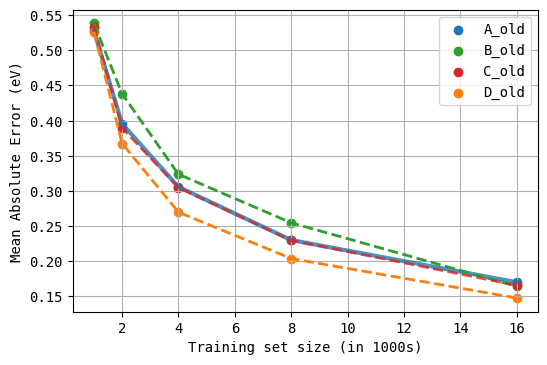

In [210]:
def plot_abcd(lop,lol):
    """
    lop: list of paths (as strings)
    lol: list of labels to be displayed on the plot
    """
    a = pd.read_csv(lop[0])
    b = pd.read_csv(lop[1])
    c = pd.read_csv(lop[2])
    d = pd.read_csv(lop[3])

    set_mpl_params_meeting(matplotlib)
    labs, labels = get_labels()
    
    lines = {"linewidth": 3}
    matplotlib.rc('lines', **lines)
    
    a.mean_vals = np.nan_to_num(a.mean_vals.to_numpy(), nan=0)
    # a_x = np.cumsum(a.batch_size.to_numpy() // 1000) # old/original exp data batch size is training size
    a_x = a.batch_size.to_numpy() // 1000
    plt.plot(a_x, a.mean_vals, color="tab:blue", alpha=0.8)
    plt.scatter(a_x, a.mean_vals, color="tab:blue", label=lol[0])
    
    lines = {"linewidth": 2}
    matplotlib.rc('lines', **lines)
    
    b_x = b.batch_size.to_numpy() // 1000
    plt.plot(b_x, b.mean_vals.to_numpy(), "--",color="tab:green")
    plt.scatter(b_x, b.mean_vals.to_numpy(), color="tab:green", label=lol[1])
    
    c_x = c.batch_size.to_numpy() // 1000
    plt.plot(c_x, c.mean_vals.to_numpy(), "--", color="tab:red", alpha=0.8)
    plt.scatter(c_x, c.mean_vals.to_numpy(), color="tab:red", label=lol[2])
    
    d.mean_vals = np.nan_to_num(d.mean_vals.to_numpy(), nan=0)
    d_x = d.batch_size.to_numpy() // 1000
    plt.plot(d_x, d.mean_vals, "--", color="tab:orange")
    plt.scatter(d_x, d.mean_vals, color="tab:orange", label=lol[3])

    xticks = np.sort(np.unique(np.concatenate([a_x, b_x, c_x, d_x])))
    print(xticks)
    plt.xticks(xticks)
    plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

list_of_paths = ["csv_files/Active_learning_results - AA_A_EXP_old.csv", 
          "csv_files/Active_learning_results - AA_B_EXP_old.csv",
          "csv_files/Active_learning_results - AA_C_EXP_old.csv",
          "csv_files/Active_learning_results - AA_D_EXP_old.csv"]
list_of_labels = ["A_old","B_old","C_old","D_old"]

plot_abcd(list_of_paths, list_of_labels)  

[ 1  2  4  8 16]


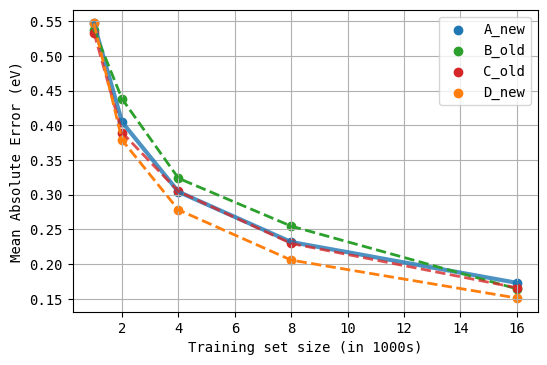

In [223]:
def plot_abcd(lop,lol):
    """
    lop: list of paths (as strings)
    lol: list of labels to be displayed on the plot
    """
    a = pd.read_csv(lop[0]); a = a[:-1]
    b = pd.read_csv(lop[1])
    c = pd.read_csv(lop[2])
    d = pd.read_csv(lop[3]); d = d[:-1]

    set_mpl_params_meeting(matplotlib)
    labs, labels = get_labels()
    
    lines = {"linewidth": 3}
    matplotlib.rc('lines', **lines)
    
    a.mean_vals = np.nan_to_num(a.mean_vals.to_numpy(), nan=0)
    a_x = np.cumsum(a.batch_size.to_numpy() // 1000) # old/original exp data batch size is training size
    # a_x = a.batch_size.to_numpy() // 1000
    plt.plot(a_x, a.mean_vals, color="tab:blue", alpha=0.8)
    plt.scatter(a_x, a.mean_vals, color="tab:blue", label=lol[0])
    
    lines = {"linewidth": 2}
    matplotlib.rc('lines', **lines)
    
    b_x = b.batch_size.to_numpy() // 1000
    plt.plot(b_x, b.mean_vals.to_numpy(), "--", color="tab:green")
    plt.scatter(b_x, b.mean_vals.to_numpy(), color="tab:green", label=lol[1])
    
    c_x = c.batch_size.to_numpy() // 1000
    plt.plot(c_x, c.mean_vals.to_numpy(), "--", color="tab:red", alpha=0.8)
    plt.scatter(c_x, c.mean_vals.to_numpy(), color="tab:red", label=lol[2])
    
    d.mean_vals = np.nan_to_num(d.mean_vals.to_numpy(), nan=0)
    d_x = np.cumsum(d.batch_size.to_numpy() // 1000)
    # d_x = d.batch_size.to_numpy() // 1000
    plt.plot(d_x, d.mean_vals, "--", color="tab:orange")
    plt.scatter(d_x, d.mean_vals, color="tab:orange", label=lol[3])

    xticks = np.sort(np.unique(np.concatenate([a_x, b_x, c_x, d_x])))
    print(xticks)
    plt.xticks(xticks)
    plt.xscale("linear")
    plt.legend()
    plt.xlabel("Training set size (in 1000s)")
    plt.ylabel("Mean Absolute Error (eV)")
    plt.grid()

list_of_paths = ["csv_files/Active_learning_results - AA_A_EXP.csv", 
                 "csv_files/Active_learning_results - AA_B_EXP_old.csv",
                 "csv_files/Active_learning_results - AA_C_EXP_old.csv",
                 "csv_files/Active_learning_results - AA_D_EXP.csv"]
list_of_labels = ["A_new","B_old","C_old","D_new"]

plot_abcd(list_of_paths, list_of_labels)      

# Check if AA A has any effect of batchsize
(Should not have significant effect)

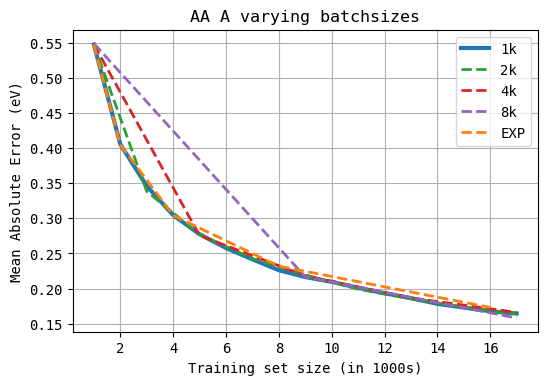

In [250]:
# for aa_a
m1,s1,b1 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_1k.csv"))
m2,s2,b2 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_2k.csv"))
m4,s4,b4 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_4k.csv"))
m8,s8,b8 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_8k.csv"))
me,se,be = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_A_EXP.csv"))

set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, m1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, m2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, m4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:purple"; plt.plot(b8, m8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:orange"; plt.plot(be[:-1], me[:-1], "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("AA A varying batchsizes")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Mean Absolute Error (eV)")
plt.grid()

# Check if AA D has any effect of batchsize

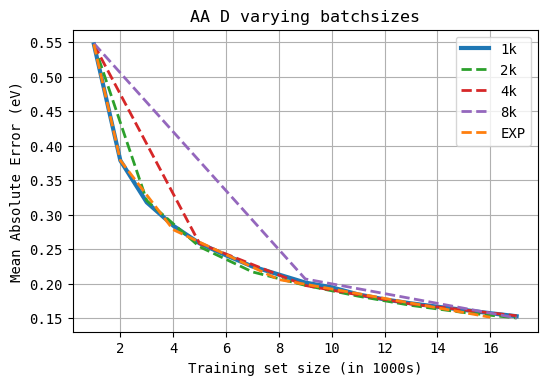

In [251]:
# for aa_d
m1,s1,b1 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_D_1k.csv"))
m2,s2,b2 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_D_2k.csv"))
m4,s4,b4 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_D_4k.csv"))
m8,s8,b8 = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_D_8k.csv"))
me,se,be = get_msb(pd.read_csv("csv_files/Active_learning_results - AA_D_EXP.csv"))

set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, m1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, m2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, m4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:purple"; plt.plot(b8, m8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:orange"; plt.plot(be[:-1], me[:-1], "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("AA D varying batchsizes")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Mean Absolute Error (eV)")
plt.grid()

# Data savings over batch size

In [252]:
def plot_data_savings_exp(strategy_a_file, strategy_d_file, batch_size, percentage=False):
    aa_a = pd.read_csv(strategy_a_file)[:-1]
    aa_d = pd.read_csv(strategy_d_file)[:-1]

    set_mpl_params(matplotlib)
    
    labs, labels = get_labels()
    
    means, stds, batch_sizes = get_means_stds_batchsize(aa_a, aa_d)
    # print(means[0], means[3], batch_sizes)
    
    coeffs, mean_dict = fit_curve_to_data(means, stds, labels, batch_sizes)
    # print(coeffs)
    data_saving = get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)
    
    data_saving = np.array(data_saving)
    batch_sizes = np.array(batch_sizes)

    print(data_saving)
    if percentage:
        data_saving = 100 * data_saving / (batch_sizes)
        
    plt.plot(batch_sizes, data_saving, color="k")
    plt.scatter(batch_sizes, data_saving, color="k")#, label="Datasaving (D vs A) in percent")
    plt.xscale("linear")
    # plt.legend()
    plt.xticks(batch_sizes)
    plt.xlabel("Dataset size in 1000s")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    return data_saving, batch_sizes

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]
[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]
[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]


/users/ghoshkun/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.00370898 0.79323291 1.69877326]
[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]


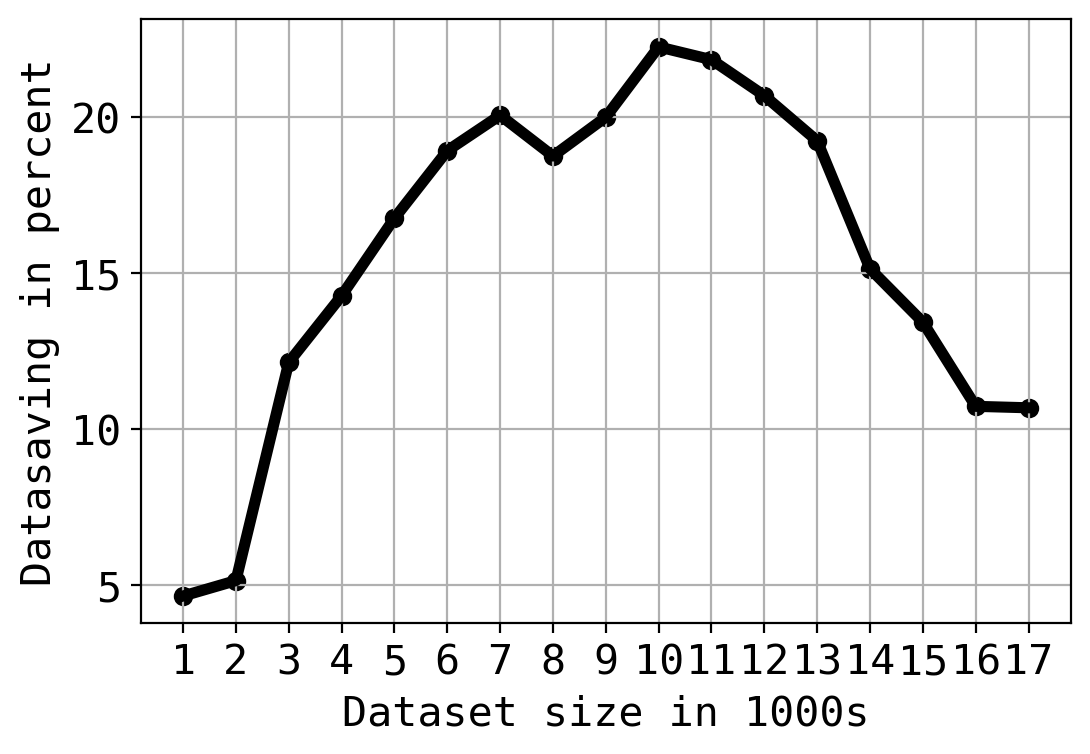

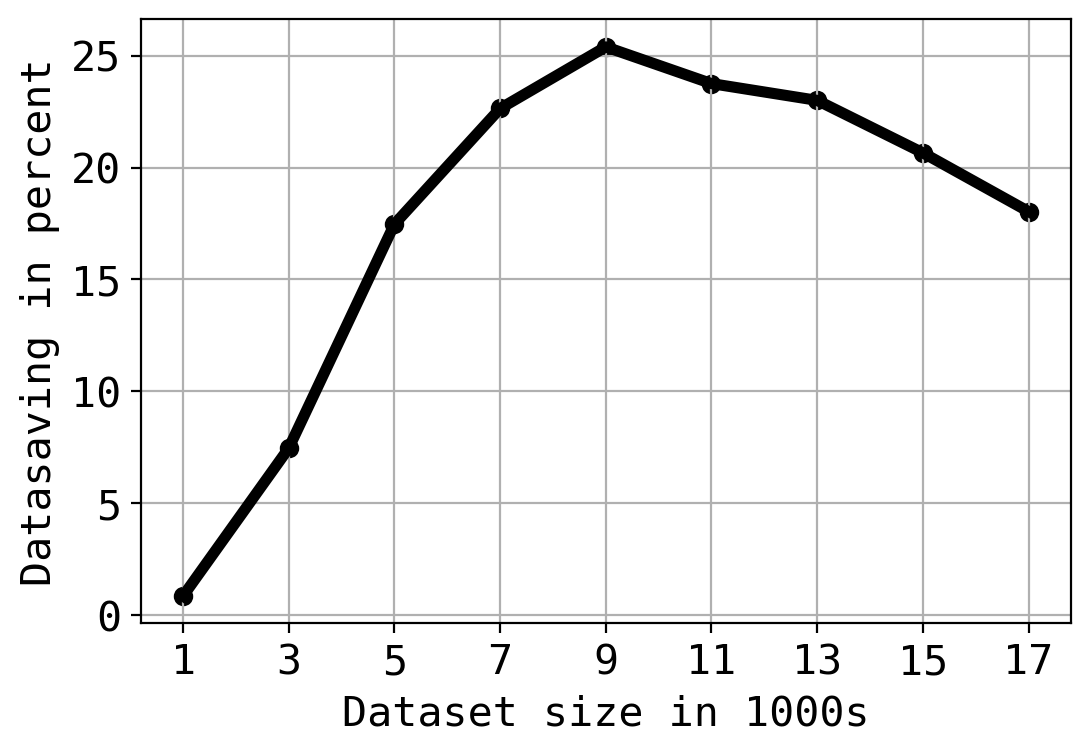

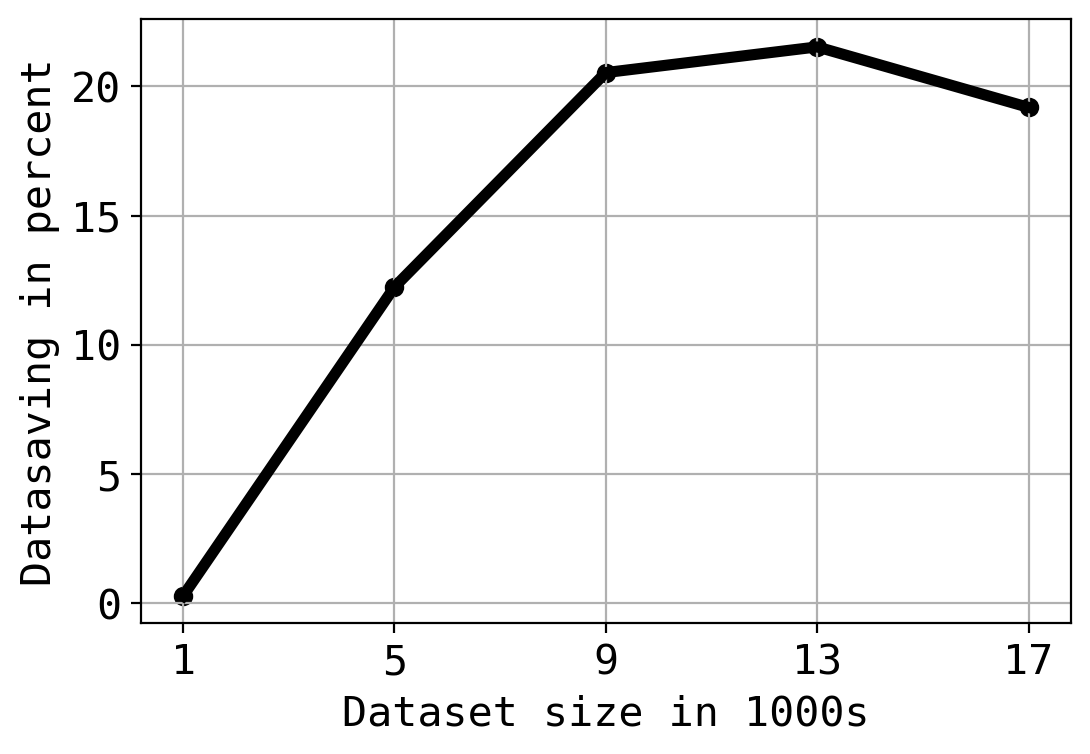

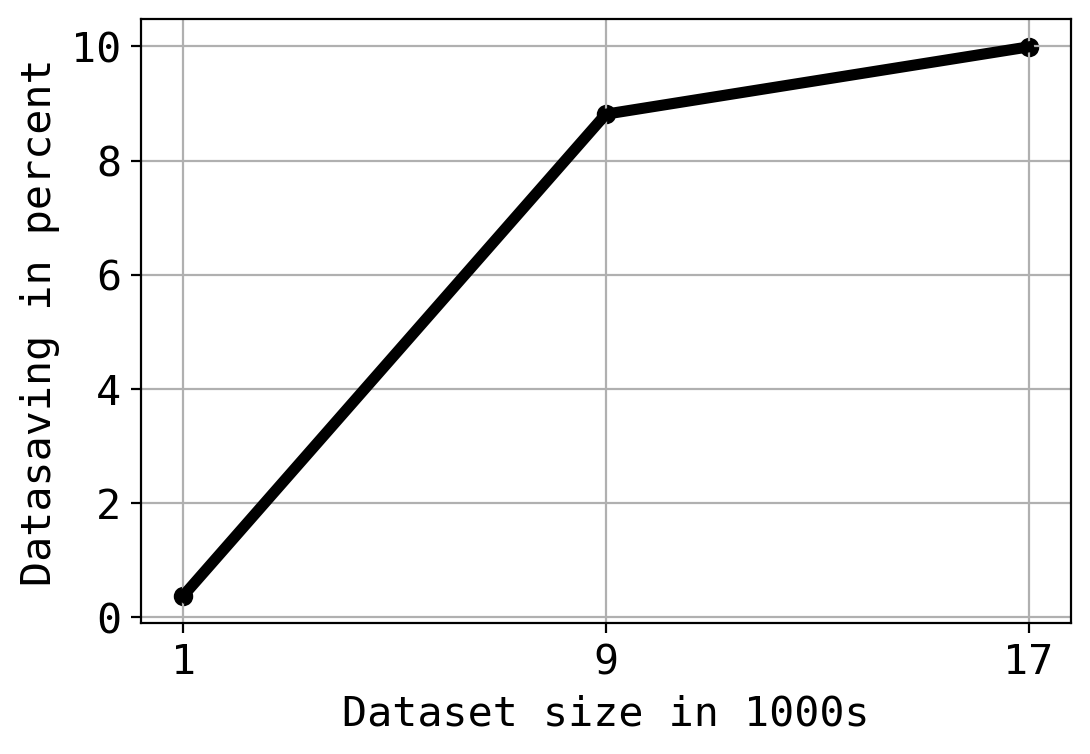

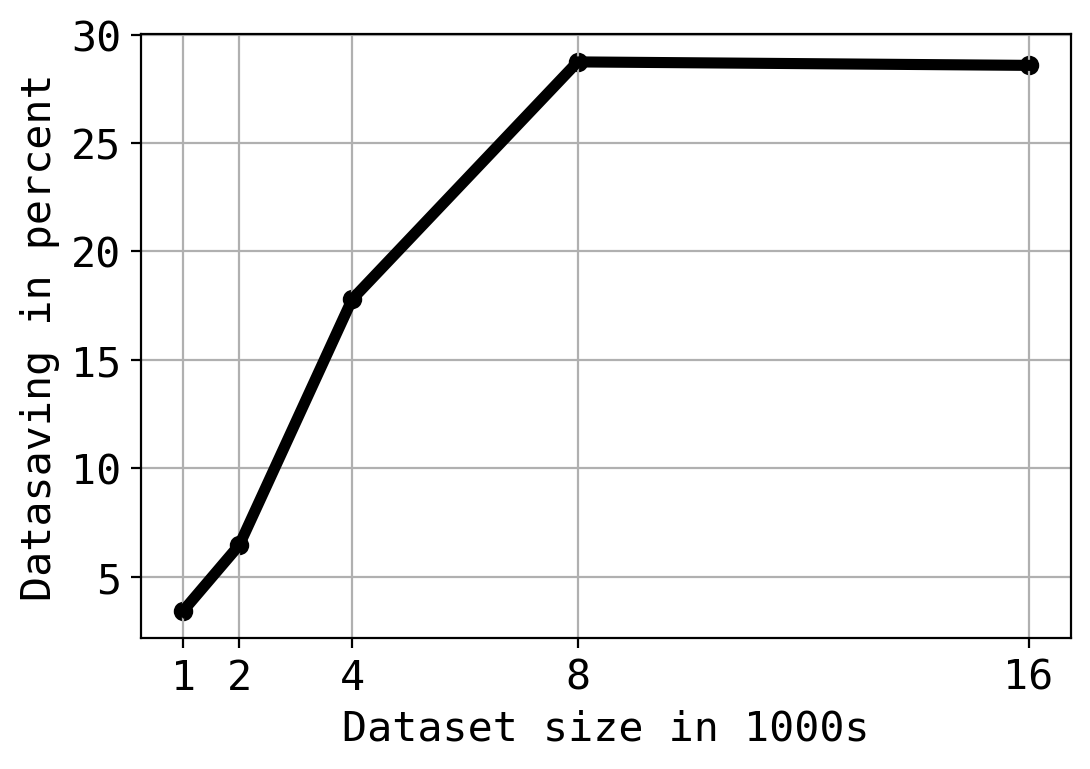

In [253]:
# for aa
%matplotlib agg
s1, b1 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s2, b2 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_2k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_2k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s4, b4 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_4k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_4k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
s8, b8 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_8k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_8k.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc
se, be = plot_data_savings_exp(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP.csv", batch_size=None, percentage=True) # 1 for 1k, 2 for 2k etc

In [256]:
se

array([ 3.41986698,  6.47119518, 17.79285091, 28.74277645, 28.58251666])

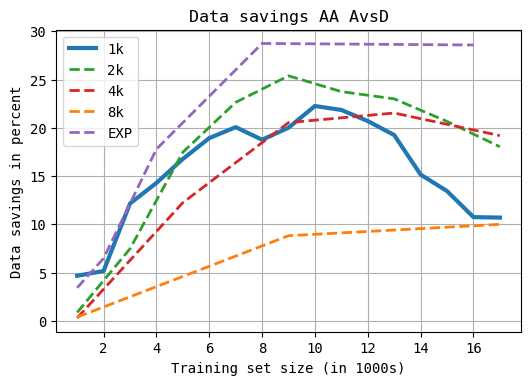

In [257]:
set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, s1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, s2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, s4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:orange"; plt.plot(b8, s8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:purple"; plt.plot(be, se, "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("Data savings AA AvsD")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Data savings in percent")
plt.grid()

# Data savings absolute value

[0.04662487 0.10309403 0.36447895 0.57135551 0.8384377  1.1359675
 1.40470688 1.50093146 1.80068159 2.22591367 2.40338128 2.48362159
 2.50240045 2.12099577 2.01583919 1.71845801 1.81789328]
[0.00859015 0.22393374 0.87348482 1.58457138 2.28497207 2.61242363
 2.98994986 3.09844738 3.06580497]
[2.85367053e-03 6.11982094e-01 1.84837656e+00 2.79905822e+00
 3.26247615e+00]


/users/ghoshkun/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.00370898 0.79323291 1.69877326]
[0.03419867 0.1294239  0.71171404 2.29942212 4.57320267]


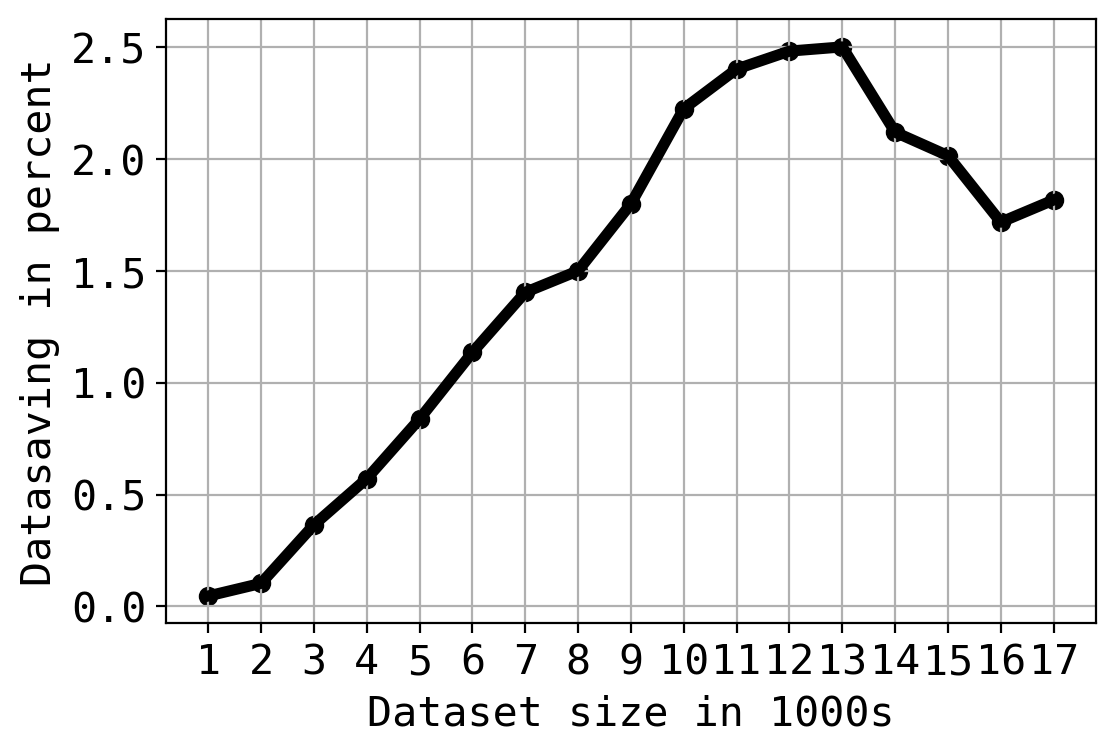

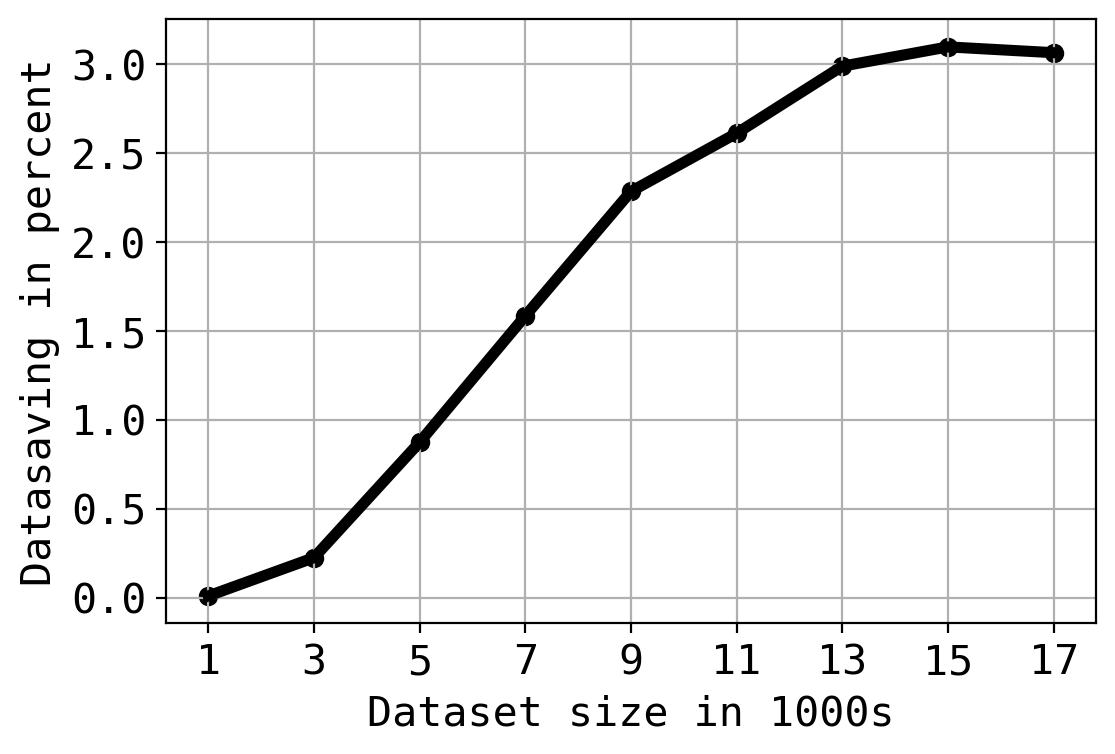

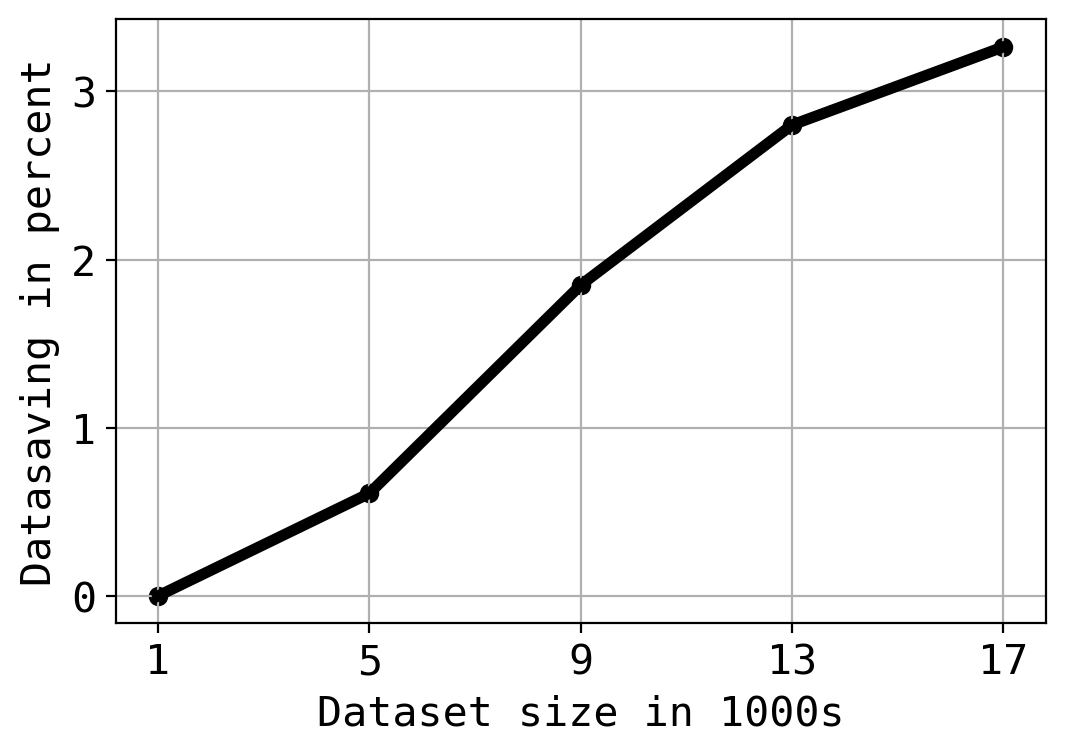

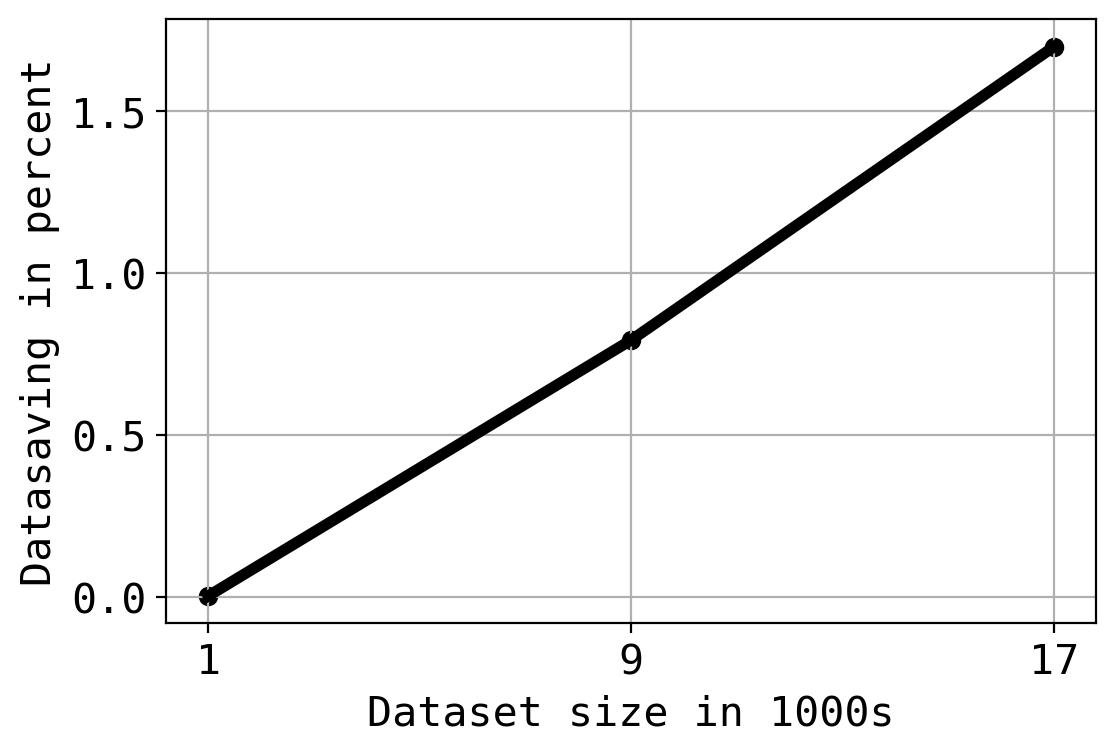

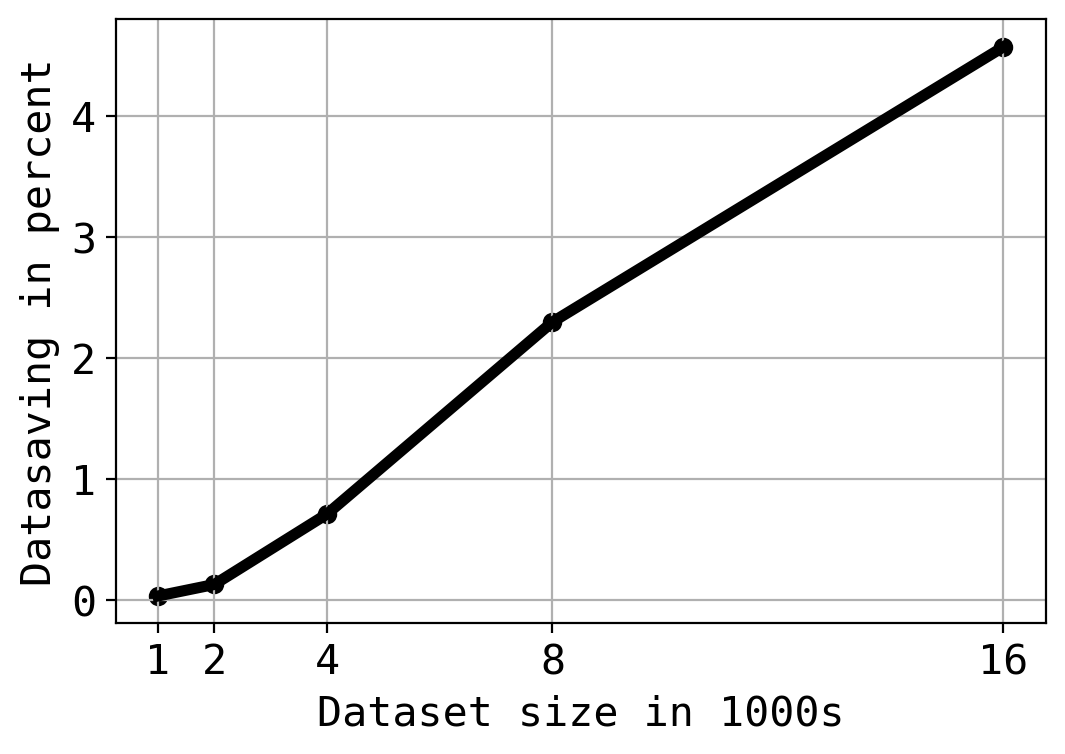

In [258]:
# for aa
%matplotlib agg
s1, b1 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s2, b2 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_2k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_2k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s4, b4 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_4k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_4k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
s8, b8 = plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_8k.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_8k.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc
se, be = plot_data_savings_exp(strategy_a_file = "csv_files/Active_learning_results - AA_A_EXP.csv", strategy_d_file = "csv_files/Active_learning_results - AA_D_EXP.csv", batch_size=None, percentage=False) # 1 for 1k, 2 for 2k etc

In [262]:
se

array([0.03419867, 0.1294239 , 0.71171404, 2.29942212, 4.57320267])

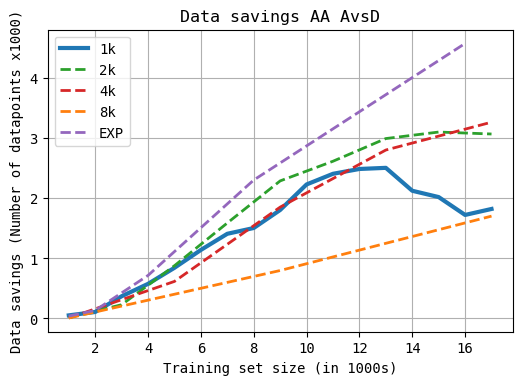

In [263]:
set_mpl_params_meeting(matplotlib)

matplotlib.rc('lines', **{"linewidth": 3}); 
color="tab:blue"; plt.plot(b1, s1, color=color, label="1k"); #plt.scatter(b1, m1, color=color, label="1k")

matplotlib.rc('lines', **{"linewidth": 2})
color="tab:green"; plt.plot(b2, s2, "--", color=color, label="2k"); #plt.scatter(b2, m2, color=color, label="2k")
color="tab:red"; plt.plot(b4, s4, "--", color=color, label="4k"); #plt.scatter(b4, m4, color=color, label="4k")
color="tab:orange"; plt.plot(b8, s8, "--",color=color, label="8k"); #plt.scatter(b8, m8, color=color, label="8k")
color="tab:purple"; plt.plot(be, se, "--",color=color, label="EXP"); #plt.scatter(be, me, color=color, label="EXP")
plt.title("Data savings AA AvsD")
plt.xscale("linear")
plt.legend()
plt.xlabel("Training set size (in 1000s)")
plt.ylabel("Data savings (Number of datapoints x1000)") # how many fewer datapoints does D require to get same MAE
plt.grid()

# Distribution of molecule count per energy range

Done for AA and QM9

In [64]:
from matplotlib import pyplot as plt

import os
import numpy as np
import matplotlib
%matplotlib inline

plt.style.use('seaborn-paper')
# font = {'size'   : 20}
# labelsize = {'labelsize'   : 20, 'titlesize' : 20}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **labelsize)
params = {'legend.fontsize': 'small',
  'axes.labelsize': 'medium',
  'axes.titlesize':'medium',
  'xtick.labelsize':'medium',
  'ytick.labelsize':'medium'}
matplotlib.rcParams.update(params)
set_mpl_params(matplotlib)

os.chdir("/projappl/project_2000382/ghoshkun/data")
aa = np.loadtxt("AA/HOMO.txt")
qm9 = np.loadtxt("QM9/HOMO.txt")

<Figure size 1200x800 with 0 Axes>

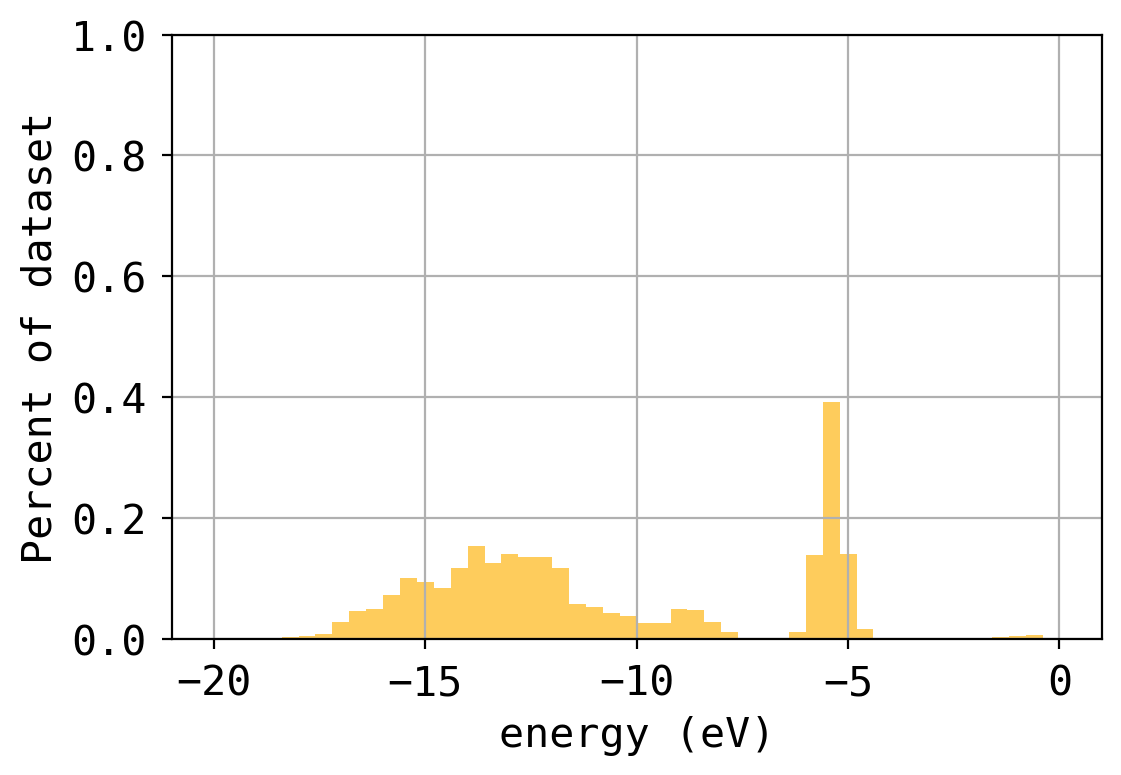

In [69]:
def plot_data_distribution(data, color):
    set_mpl_params(matplotlib)
    obj = plt.hist(data, bins=50, density=True, color=color,range=[-20, 0])
    plt.ylim((0,1))
    plt.xlabel("energy (eV)")
    plt.ylabel("Percent of dataset")
    plt.grid(True)
    
plot_data_distribution(aa, "#fecc5c")

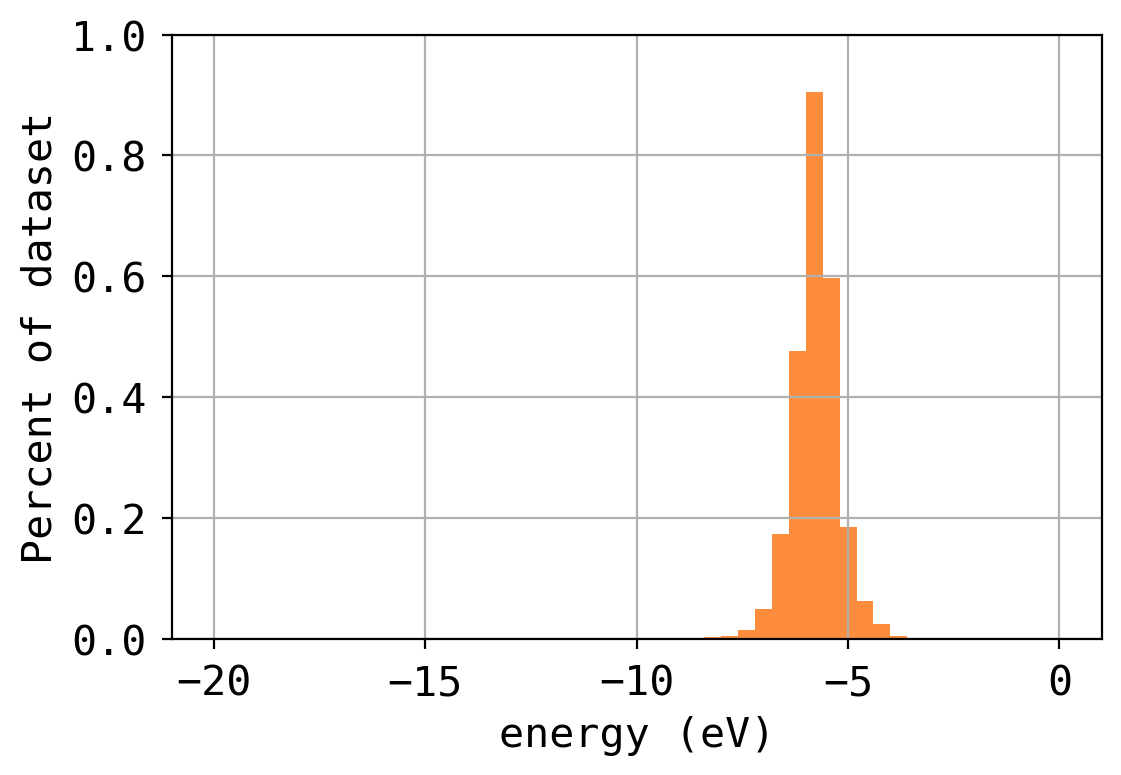

In [70]:
# obj = plt.hist(qm9, bins=50, density=True, color="#fd8d3c",range=[-20, 0])  
# plt.ylim((0,1))
# plt.xlabel("energy (eV)")
# plt.ylabel("Percent of dataset")

plot_data_distribution(qm9, "#fd8d3c")

In [ ]:
# plot figure 1
def plot_all_datasets():
    set_mpl_params(matplotlib)
    qm9 = pd.read_csv("csv_files/Active_learning_results - QM9_A_EXP_old.csv")
    aa  = pd.read_csv("csv_files/Active_learning_results - AA_A_EXP_old.csv")
    
    